In [1]:
#useful libraries
import sys
import numpy as np
import os
import pandas as pd  

#Common Model Helpers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, hamming_loss, roc_curve,average_precision_score
from sklearn.metrics import plot_confusion_matrix, auc,roc_curve, log_loss, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

#Visualization
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pandas.plotting import scatter_matrix

#pickle to save model
import pickle
from joblib import dump, load

mpl.style.use('ggplot')
sn.set_style('white')
sn.set(font_scale=1.4)
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
#import data
dataset = pd.read_csv('real.csv')
data = dataset[['1','2']]
x = list(data['1'])
y = list(data['2'])

x = np.asarray(x).astype(str)
y = np.asarray(y).astype(str)

#splitting dataset
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=43)

In [3]:
new  = []
new2 = []
new3  = []
new4 = []

#converting the 64-bit into an array with 64 items 
for i in range(len(x_train)):
    new.append(list(map(int,x_train[i])))
    new2.append(list(map(int,y_train[i])))

for j in range(len(x_test)):
    new3.append(list(map(int,x_test[j])))
    new4.append(list(map(int,y_test[j])))

x_train = np.asarray(new).astype(int)
y_train = np.asarray(new2).astype(int)
x_test = np.asarray(new3).astype(int)
y_test = np.asarray(new4).astype(int)


In [4]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
# apply same transformation to test data
x_test = scaler.transform(x_test)
x_test = scaler.transform(y_test)

In [5]:
#classificiation for True Negative, True Positive, False Negative & False Positive
def classfication(predictions):
    TN = 0
    TP = 0
    FN = 0
    FP = 0

    for i in range(len(predictions)):
        for j in range (len(predictions[i])):
            if predictions[i][j] == 0 and y_test[i][j] == 0:
                TN = TN + 1
            elif predictions[i][j] == 1 and y_test[i][j] == 1:
                TP = TP + 1
            elif predictions[i][j] == 0 and y_test[i][j] == 1:
                FN = FN + 1
            elif predictions[i][j] == 1 and y_test[i][j] == 0:
                FP = FP + 1
    
    return TN,TP,FN,FP

#Metrics for evaluation
def metrics (TN,TP,FN,FP):
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)
    f1 =  (2*(precision*recall))/(precision + recall)

    return accuracy,recall,precision,f1

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(256,512,512,256), 
                    max_iter=1,
                    activation = "relu",
                    verbose = True,
                    solver = "adam",
                    random_state= 60,
                    tol=0.00005,
                    learning_rate = 'adaptive',)


accuracy = []
precision = []
recall = []
hloss = []
loss = []
f1_score = []
mcc= []

mlp.fit(x_train, y_train)
dump(mlp, 'predictor.joblib')
for i in range (3):
    mlp = load('predictor.joblib')
    mlp.partial_fit(x_train, y_train)
    predictions = mlp.predict(x_test)
    TN,TP,FN,FP = classfication(predictions)
    acc,rec,prec,f1 =  metrics(TN,TP,FN,FP)
    accuracy.append(round(acc,3))
    precision.append(round(prec,3))
    recall.append(round(rec,3))
    hloss.append(round(hamming_loss(y_test,predictions),3))
    loss.append(round(mlp.loss_,3))
    f1_score.append(round(f1,3))
    dump(mlp, 'predictor.joblib')
    #print(classification_report(y_test,predictions,zero_division=1))

Iteration 1, loss = 27.46934674


/Users/jerrywu/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 27.09565725


In [18]:
print(accuracy)
print(precision)
print(recall)
print(hloss)
print(loss)
print(f1_score)

[0.752, 0.751, 0.751]
[0.786, 0.778, 0.777]
[0.727, 0.736, 0.738]
[0.248, 0.249, 0.249]
[27.096, 27.032, 26.957]
[0.755, 0.757, 0.757]


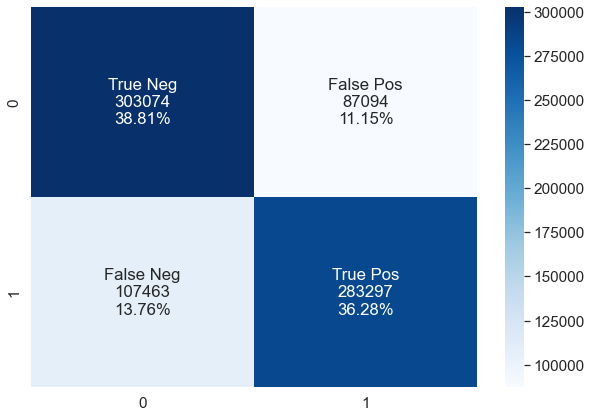

In [20]:
#confusion matrix graphing
cf_matrix = [TP,FP,FN,TN]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

cf_matrix = [[TP,FP],[FN,TN]]
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig(os.path.join(sys.path[0],'confusion matrix.png'))